In [1]:
# https://pymc-devs.github.io/pymc3/notebooks/dp_mix.html


# The Dirichlet process mixture model is incredibly flexible in terms of the family of parametric component distributions {fθ | fθ∈Θ}{fθ | fθ∈Θ}. We illustrate this flexibility below by using Poisson component distributions to estimate the density of sunspots per year.




In [2]:
# pymc3.distributions.DensityDist?

In [3]:

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as tt

%matplotlib inline

%load_ext version_information

%version_information pymc3, statsmodels, pandas

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
statsmodels 0.8.0
pandas 0.20.3
Wed Aug 30 17:39:29 2017 MDT

## Generating data

In [4]:
sunspot_df = get_rdataset('sunspot.year', cache=True).data
sunspot_df.head()

,time,sunspot.year
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


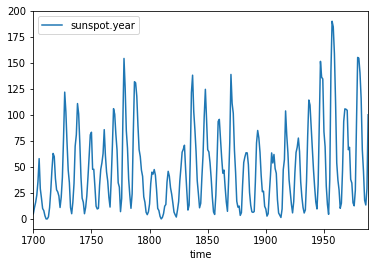

In [5]:
sunspot_df.plot(x='time')

## Model specification
Our initial beliefs about the parameters are quite informative (sd=1) and a bit off the true values.

We will use the model:

$\alpha \sim Gamma(1,1) \\
\beta_1,...,\beta_k \sim Beat(1,\alpha) \\
w_i = \beta_i \prod^i_{j=i-1}(1-\beta_j \\
\lambda_i,...,\lambda_k \sim U(0,300) \\
x | w_i,\lambda_i \sim \sum^K_{i=1}w_i Poisson(\lambda_i)$


In [6]:
SEED = 8675309 # from random.org

np.random.seed(SEED)

In [7]:
K = 50
N = sunspot_df.shape[0]

In [8]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [9]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    mu = pm.Uniform('mu', 0., 300., shape=K)
    obs = pm.Mixture('obs', w, pm.Poisson.dist(mu), observed=sunspot_df['sunspot.year'])

In [10]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, tune=90000, random_seed=SEED, njobs=6)

100%|██████████| 100000/100000 [04:16<00:00, 390.57it/s]


For the sunspot model, the posterior distribution of αα is concentrated between 0.6 and 1.2, indicating that we should expect more components to contribute non-negligible amounts to the mixture than for the Old Faithful waiting time model.

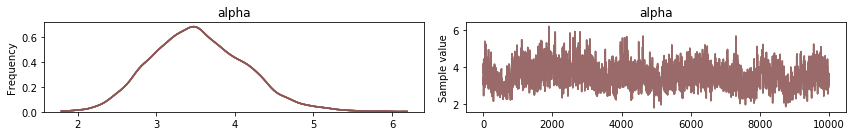

In [11]:
pm.traceplot(trace, varnames=['alpha']);


Indeed, we see that between ten and fifteen mixture components have appreciable posterior expected weight.



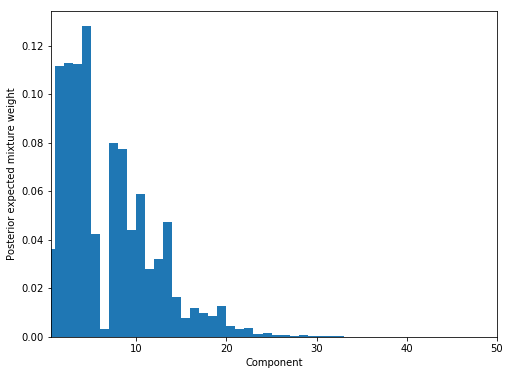

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

We now calculate and plot the fitted density estimate.



In [ ]:
x_plot = np.arange(250)


In [ ]:
post_pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot),
                                         trace['mu'][:, np.newaxis, :])
post_pmfs = (trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);

ax.fill_between(x_plot, post_pmf_low, post_pmf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pmfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pmfs[::200].T, c='gray');
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

Again, we can decompose the posterior expected density into weighted mixture densities.



In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected\nmixture components\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

What are the peaks of each of the components?
